<a href="https://colab.research.google.com/github/Lexaun-chen/STAT-4830-Group-Project/blob/main/notebooks%5CMatrix_Completion_with_SGD_and_NQM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class MF():

    def __init__(self, X, k, alpha, beta, iterations):
        """
        Perform matrix factorization to predict np.nan entries in a matrix.
        Arguments
        - X (ndarray)   : sample-feature matrix
        - k (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.X = X
        self.num_samples, self.num_features = X.shape
        self.k = k
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        # True if not nan
        self.not_nan_index = (np.isnan(self.X) == False)

    def train(self):
        # Initialize factorization matrix U and V
        self.U = np.random.normal(scale=1./self.k, size=(self.num_samples, self.k))
        self.V = np.random.normal(scale=1./self.k, size=(self.num_features, self.k))

        # Initialize the biases
        self.b_u = np.zeros(self.num_samples)
        self.b_v = np.zeros(self.num_features)
        self.b = np.mean(self.X[np.where(self.not_nan_index)])
        # Create a list of training samples
        self.samples = [
            (i, j, self.X[i, j])
            for i in range(self.num_samples)
            for j in range(self.num_features)
            if not np.isnan(self.X[i, j])
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            # total square error
            se = self.square_error()
            training_process.append((i, se))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, se))

        return training_process

    def square_error(self):
        """
        A function to compute the total square error
        """
        predicted = self.full_matrix()
        error = 0
        for i in range(self.num_samples):
            for j in range(self.num_features):
                if self.not_nan_index[i, j]:
                    error += pow(self.X[i, j] - predicted[i, j], 2)
        return error

    def sgd(self):
        """
        Perform stochastic graident descent(SGD)
        """
        for i, j, x in self.samples:
            # Computer prediction and error
            prediction = self.get_x(i, j)
            e = (x - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (2 * e - self.beta * self.b_u[i])
            self.b_v[j] += self.alpha * (2 * e - self.beta * self.b_v[j])

            # Update factorization matrix U and V
            """
            If RuntimeWarning: overflow encountered in multiply,
            then turn down the learning rate alpha.
            """
            self.U[i, :] += self.alpha * (2 * e * self.V[j, :] - self.beta * self.U[i,:])
            self.V[j, :] += self.alpha * (2 * e * self.U[i, :] - self.beta * self.V[j,:])

    def get_x(self, i, j):
        """
        Get the predicted x of sample i and feature j
        """
        prediction = self.b + self.b_u[i] + self.b_v[j] + self.U[i, :].dot(self.V[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Compute the full matrix using the resultant biases, U and V
        """
        return self.b + self.b_u[:, np.newaxis] + self.b_v[np.newaxis, :] + self.U.dot(self.V.T)

    def replace_nan(self, X_hat):
        """
        Replace np.nan of X with the corresponding value of X_hat
        """
        X = np.copy(self.X)
        for i in range(self.num_samples):
            for j in range(self.num_features):
                if np.isnan(X[i, j]):
                    X[i, j] = X_hat[i, j]
        return X


In [32]:
class MF_NQM():

    def __init__(self, X, k, alpha, beta, iterations, noise_var=0.01):
        """
        Perform matrix factorization with noisy SGD to predict np.nan entries in a matrix.
        Arguments:
        - X (ndarray)   : sample-feature matrix
        - k (int)       : number of latent dimensions
        - alpha (float) : initial learning rate (will be optimized)
        - beta (float)  : regularization parameter
        - iterations (int) : number of SGD iterations
        - noise_var (float) : variance of added SGD noise
        """
        self.X = X
        self.num_samples, self.num_features = X.shape
        self.k = k
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.noise_var = noise_var
        # True if not nan
        self.not_nan_index = (np.isnan(self.X) == False)

    def train(self):
        # Initialize factorization matrix U and V
        self.U = np.random.normal(scale=1./self.k, size=(self.num_samples, self.k))
        self.V = np.random.normal(scale=1./self.k, size=(self.num_features, self.k))

        # Initialize the biases
        self.b_u = np.zeros(self.num_samples)
        self.b_v = np.zeros(self.num_features)
        self.b = np.nanmean(self.X)

        # Create a list of training samples
        self.samples = [
            (i, j, self.X[i, j])
            for i in range(self.num_samples)
            for j in range(self.num_features)
            if not np.isnan(self.X[i, j])
        ]

        # Optimize learning rate using `optimal_ttl()`
        self.alpha = self.find_optimal_lrate()

        # Perform stochastic gradient descent for a number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            # total square error
            se = self.square_error()
            training_process.append((i, se))
            if (i+1) % 10 == 0:
                print(f"Iteration: {i+1} ; error = {se:.4f}")

        return training_process

    def square_error(self):
        """
        Compute the total square error
        """
        predicted = self.full_matrix()
        error = 0
        for i in range(self.num_samples):
            for j in range(self.num_features):
                if self.not_nan_index[i, j]:
                    error += pow(self.X[i, j] - predicted[i, j], 2)
        return error / np.sum(self.not_nan_index)  # Normalize by observed values

    def sgd(self):
        """
        Perform stochastic gradient descent with noisy updates
        """
        for i, j, x in self.samples:

            # Compute prediction and error
            prediction = self.get_x(i, j)
            e = x - prediction

            max_grad = 5.0  # Gradient clipping threshold

            # Add Gaussian noise to simulate SGD variance
            noise_u = np.random.normal(0, np.sqrt(self.noise_var), size=(self.k,))
            noise_v = np.random.normal(0, np.sqrt(self.noise_var), size=(self.k,))

            # Update biases
            self.b_u[i] += self.alpha * (2 * e - self.beta * self.b_u[i])
            self.b_v[j] += self.alpha * (2 * e - self.beta * self.b_v[j])

            # Update factorization matrix U and V
            self.U[i, :] += self.alpha * (2 * e * self.V[j, :] - self.beta * self.U[i, :]) + noise_u
            self.V[j, :] += self.alpha * (2 * e * self.U[i, :] - self.beta * self.V[j, :]) + noise_v

            self.U[i, :] = np.clip(self.U[i, :], -max_grad, max_grad)
            self.V[j, :] = np.clip(self.V[j, :], -max_grad, max_grad)

    def get_x(self, i, j):
        """
        Get the predicted x of sample i and feature j
        """
        return self.b + self.b_u[i] + self.b_v[j] + self.U[i, :].dot(self.V[j, :].T)

    def full_matrix(self):
        """
        Compute the full matrix using the resultant biases, U and V
        """
        return self.b + self.b_u[:, np.newaxis] + self.b_v[np.newaxis, :] + self.U.dot(self.V.T)

    def replace_nan(self, X_hat):
        """
        Replace np.nan of X with the corresponding value of X_hat
        """
        X = np.copy(self.X)
        X[np.isnan(X)] = X_hat[np.isnan(X)]
        return X

    def find_optimal_lrate(self):
        """
        Find the optimal learning rate using `optimal_ttl()`
        """
        lrates = np.logspace(-5, 0.5, 50 )  # Generate candidate learning rates
        best, best_lrate = np.inf, None

        for lrate in lrates:
            num_steps = self.time_to_loss(lrate)
            if num_steps < best:
                best = num_steps
                best_lrate = lrate
        return best_lrate

    def time_to_loss(self, lrate):
        """
        Determine the time it takes to reach a predefined loss threshold using `simulate_kstep_dynamics()`
        """
        num_steps = 1000
        loss_threshold = 1e-3
        losses = []

        for k in range(num_steps):
            self.sgd()
            loss_k = self.square_error()
            losses.append(loss_k)
            if loss_k < loss_threshold:
                return k  # Return the number of steps to reach the threshold
        return num_steps  # Return max steps if not converged



Original Matrix (with Nans):
[[ 5.  3. nan  1.]
 [ 4. nan nan  1.]
 [ 1.  1. nan  5.]
 [ 1. nan nan  4.]
 [nan  1.  5.  4.]]

Scaled Matrix (with Nans):
[[1.  0.6 nan 0.2]
 [0.8 nan nan 0.2]
 [0.2 0.2 nan 1. ]
 [0.2 nan nan 0.8]
 [nan 0.2 1.  0.8]] 

Iteration: 20 ; error = 1.3416
Iteration: 40 ; error = 1.2082
Iteration: 60 ; error = 1.1376
Iteration: 80 ; error = 1.0774
Iteration: 100 ; error = 1.0096
Iteration: 120 ; error = 0.9202
Iteration: 140 ; error = 0.7984
Iteration: 160 ; error = 0.6430
Iteration: 180 ; error = 0.4723
Iteration: 200 ; error = 0.3175
Iteration: 220 ; error = 0.2037
Iteration: 240 ; error = 0.1326
Iteration: 260 ; error = 0.0926
Iteration: 280 ; error = 0.0708
Iteration: 300 ; error = 0.0589

SGD Predicted Matrix (X_hat):
[[4.78913535 2.6895903  6.46728666 1.46534   ]
 [3.6168677  1.4119645  5.73476925 1.35964404]
 [1.3148708  0.96773707 3.89005465 4.6567123 ]
 [1.33665308 1.10080975 3.49938566 3.70659998]
 [2.47254251 1.52447418 4.79067108 3.67886917]]

SGD 

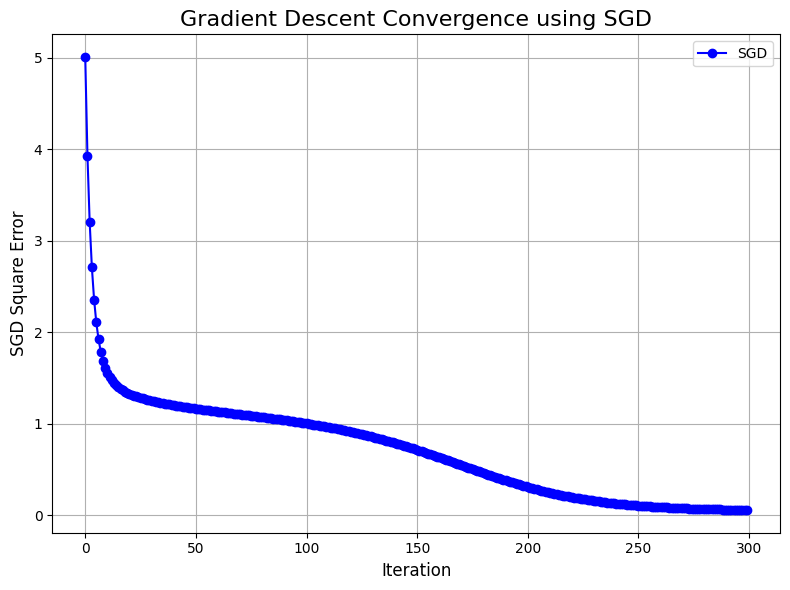

Iteration: 10 ; error = 0.0480
Iteration: 20 ; error = 0.0901
Iteration: 30 ; error = 0.0927
Iteration: 40 ; error = 0.1145
Iteration: 50 ; error = 0.1536

NQM Predicted Matrix (X_hat):
[[ 5.14224084 -0.35305836  2.04111736  4.14635081]
 [ 0.76769579  3.30004658  2.43098057  0.07991275]
 [ 2.1917975   2.56997089  3.53862672  2.72104913]
 [ 3.62751344  1.06760777  3.22788541  4.04034092]
 [-0.8873225   1.98774794  4.64837289  3.39482447]]

NQM Completed Matrix (X_comp):
[[ 5.          3.          2.04111736  1.        ]
 [ 4.          3.30004658  2.43098057  1.        ]
 [ 1.          1.          3.53862672  5.        ]
 [ 1.          1.06760777  3.22788541  4.        ]
 [-0.8873225   1.          5.          4.        ]]


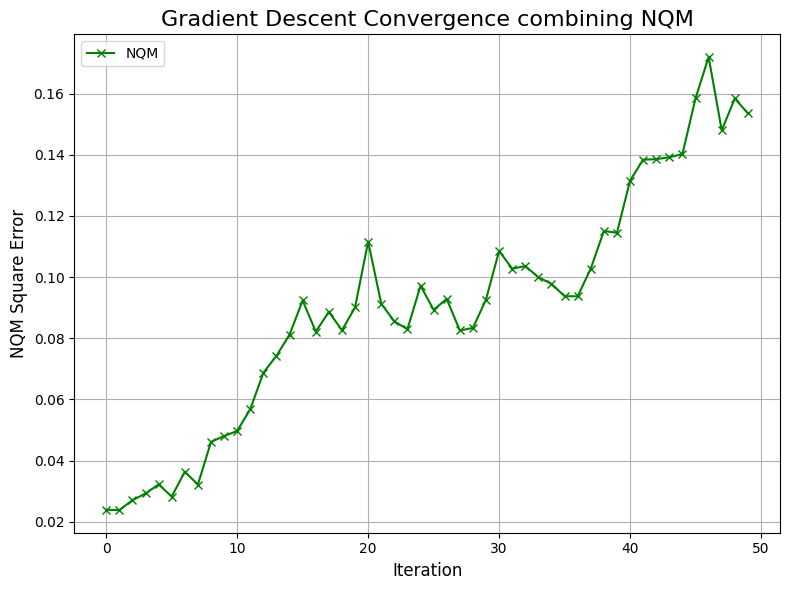

In [33]:
if __name__ == '__main__':
    X = np.array([
        [5, 3, 0, 1],
        [4, 0, 0, 1],
        [1, 1, 0, 5],
        [1, 0, 0, 4],
        [0, 1, 5, 4],
    ], dtype=float)
    # Replace 0 with np.nan
    X[X == 0] = np.nan

    # Scale the data to the range [0, 1] for the non-nan values
    X_scaled = X / np.nanmax(X)

    print("\nOriginal Matrix (with Nans):")
    print(X)

    print("\nScaled Matrix (with Nans):")
    print(X_scaled,"\n")

    np.random.seed(1)


#1. Use SGD
    mf_sgd = MF(X_scaled, k=2, alpha=0.01, beta=0.1, iterations=300)
    sgd_training_process = mf_sgd.train()

    # Unscale the predicted matrix to the original scale
    sgd_X_hat_scaled = mf_sgd.full_matrix()

    sgd_X_comp_scaled = mf_sgd.replace_nan(sgd_X_hat_scaled)
    sgd_X_comp = sgd_X_comp_scaled * np.nanmax(X)
    sgd_X_hat = sgd_X_hat_scaled * np.nanmax(X)

    print("\nSGD Predicted Matrix (X_hat):")
    print(sgd_X_hat)
    print("\nSGD Completed Matrix (X_comp):")
    print(sgd_X_comp)

    # Plot the error over iterations
    sgd_iterations, sgd_errors = zip(*sgd_training_process)

    plt.figure(figsize=(8, 6))
    plt.plot(sgd_iterations, sgd_errors, marker='o', linestyle='-', color='b', label='SGD')
    plt.title('Gradient Descent Convergence using SGD', fontsize=16)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('SGD Square Error', fontsize=12)

    plt.grid(True)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()



#2. Combine NQM
    mf_nqm = MF_NQM(X_scaled, k=2, alpha=0.01, beta=0.1, iterations=50, noise_var=0.001)
    nqm_training_process = mf_nqm.train()

    # Unscale the predicted matrix to the original scale
    nqm_X_hat_scaled = mf_nqm.full_matrix()

    nqm_X_comp_scaled = mf_nqm.replace_nan(nqm_X_hat_scaled)
    nqm_X_comp = nqm_X_comp_scaled * np.nanmax(X)
    nqm_X_hat = nqm_X_hat_scaled * np.nanmax(X)

    print("\nNQM Predicted Matrix (X_hat):")
    print(nqm_X_hat)
    print("\nNQM Completed Matrix (X_comp):")
    print(nqm_X_comp)


    # Plot the error over iterations
    nqm_iterations, nqm_errors = zip(*nqm_training_process)

    plt.figure(figsize=(8, 6))
    plt.plot(nqm_iterations, nqm_errors, marker='x', linestyle='-', color='g', label='NQM')
    plt.title('Gradient Descent Convergence combining NQM', fontsize=16)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('NQM Square Error', fontsize=12)

    plt.grid(True)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()


Generated matrix completion dataset: 20 x 20, rank 3, 60.0% observed entries

Original Matrix (with Nans):
[[-0.84935808         nan         nan         nan         nan         nan
          nan         nan  3.63521026         nan         nan         nan
          nan  2.26765609         nan -2.62956514         nan         nan
          nan         nan]
 [ 1.65125147         nan         nan -0.69878495         nan -0.20162617
  -3.50254967         nan         nan         nan         nan         nan
          nan         nan -0.78110686  5.26305113         nan         nan
          nan         nan]
 [        nan  2.72977365         nan         nan         nan -0.16941867
          nan  2.06406579         nan -3.28053079         nan         nan
          nan         nan         nan         nan         nan         nan
          nan  0.91667852]
 [        nan         nan         nan         nan         nan -0.15400561
  -2.80776737         nan         nan  1.93188697         nan         n

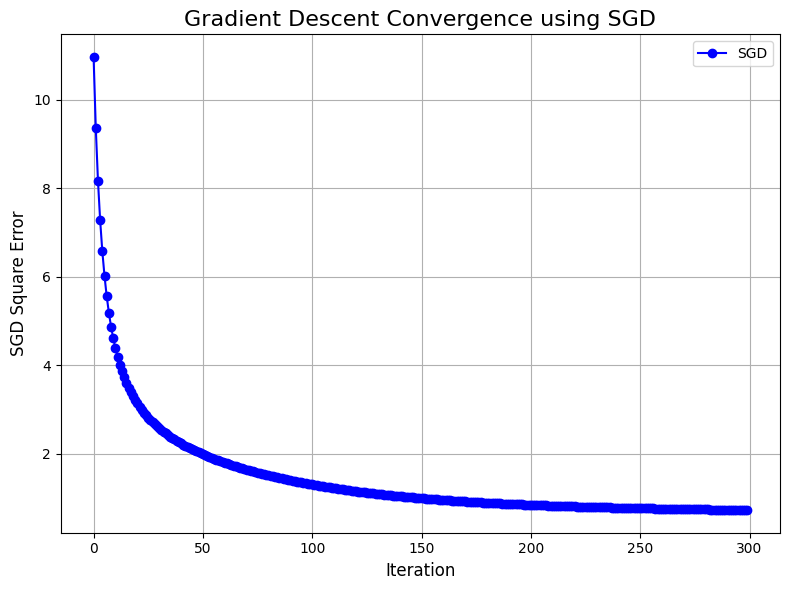

Iteration: 10 ; error = 0.5794
Iteration: 20 ; error = 0.7195
Iteration: 30 ; error = 0.9541
Iteration: 40 ; error = 1.5794
Iteration: 50 ; error = 1.9434
Iteration: 60 ; error = 2.8082
Iteration: 70 ; error = 3.5252
Iteration: 80 ; error = 3.9446
Iteration: 90 ; error = 3.9939
Iteration: 100 ; error = 5.4179

NQM Predicted Matrix (X_hat):
[[-2.48157222e+01  4.96367738e+01 -5.44063873e+01  2.80466586e+01
  -7.49939085e+00  4.01810834e+01 -2.62004784e+01  1.14283894e+01
   1.51549877e+01 -4.89417687e+01 -1.78439119e+00  1.22854610e+01
  -1.26916060e+01 -1.04774384e+01  3.94262023e+01  2.58960849e+01
  -4.04923443e+00 -9.50834563e+00 -1.24781974e+00 -9.59405216e+00]
 [ 2.12689464e+01 -1.63955651e+01  3.21605461e+01 -5.06812285e+00
   5.73406039e+00 -5.65123040e+00  3.22481255e+00  1.90454314e+00
  -3.33669028e+00  7.98733788e+00  9.35660896e-02  8.39496963e+00
   2.62404323e+00 -2.83484164e+00 -1.06965073e+01 -2.52801855e+01
   7.06042001e+00  2.93658130e+00  1.29690407e+01  2.53387019e+

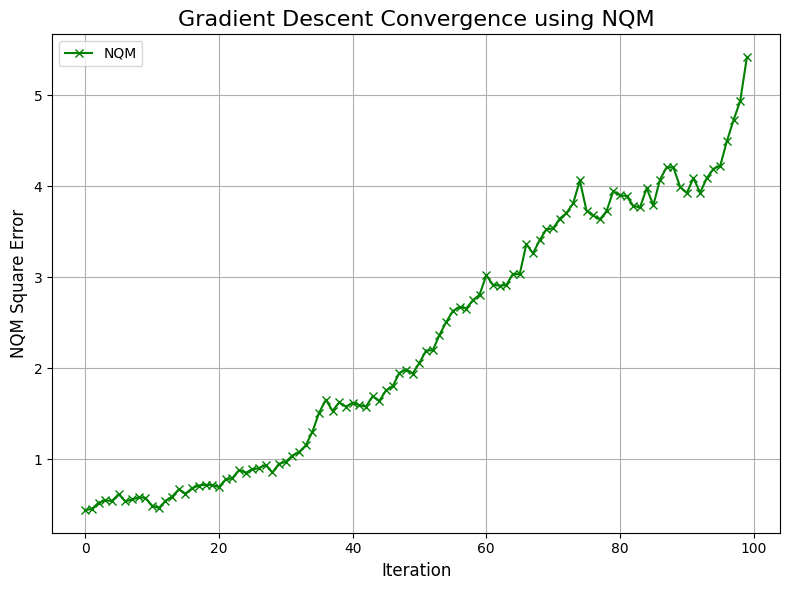

In [34]:
# Data set generation for large-scale matrix completion task

if __name__ == "__main__":

    np.random.seed(1)

    # Define matrix dimensions and rank
    n1, n2, r = 20, 20, 3  # Generate a 20x20 low-rank matrix with rank 3

    # Generate a low-rank matrix M
    M = np.random.randn(n1, r) @ np.random.randn(r, n2)

    # Compute degrees of freedom and determine the number of observed values
    df = r * (n1 + n2 - r)
    m = min(6 * df, round(0.2 * n1 * n2))  # Select 20% of entries as observed data
    p = 3 * m / (n1 * n2)  # Observation rate

    # Randomly select observed indices
    Omega = np.random.choice(n1 * n2, m, replace=False)
    data = M.flatten()[Omega]

    # Optional: Add noise to simulate real-world data
    sigma_noise = 0.01  # Noise variance
    data += sigma_noise * np.random.randn(*data.shape)

    # Create the incomplete matrix X with missing values
    X = np.full((n1, n2), np.nan)
    X.flat[Omega] = data

    print(f"\nGenerated matrix completion dataset: {n1} x {n2}, rank {r}, {100 * p:.1f}% observed entries")

    # Scale the data to the range [0, 1] for the non-nan values
    X_scaled = X / np.nanmax(X)

    print("\nOriginal Matrix (with Nans):")
    print(X)

    print("\nScaled Matrix (with Nans):")
    print(X_scaled, "\n")

    np.random.seed(1)



    #1. Apply SGD
    mf_sgd = MF(X_scaled, k=2, alpha=0.01, beta=0.1, iterations=300)
    sgd_training_process = mf_sgd.train()

    # Unscale the predicted matrix to the original scale
    sgd_X_hat_scaled = mf_sgd.full_matrix()

    sgd_X_comp_scaled = mf_sgd.replace_nan(sgd_X_hat_scaled)
    sgd_X_comp = sgd_X_comp_scaled * np.nanmax(X)
    sgd_X_hat = sgd_X_hat_scaled * np.nanmax(X)

    print("\nSGD Predicted Matrix (X_hat):")
    print(sgd_X_hat)
    print("\nSGD Completed Matrix (X_comp):")
    print(sgd_X_comp)

    # Plot the error over iterations
    sgd_iterations, sgd_errors = zip(*sgd_training_process)

    plt.figure(figsize=(8, 6))
    plt.plot(sgd_iterations, sgd_errors, marker='o', linestyle='-', color='b', label='SGD')
    plt.title('Gradient Descent Convergence using SGD', fontsize=16)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('SGD Square Error', fontsize=12)

    plt.grid(True)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()



    # 2. Apply NQM-based Matrix Factorization
    mf_nqm = MF_NQM(X_scaled, k=3, alpha=0.001, beta=0.1, iterations=100, noise_var=0.001)
    nqm_training_process = mf_nqm.train()

    # Unscale the predicted matrix to the original scale
    nqm_X_hat_scaled = mf_nqm.full_matrix()

    # Replace NaN values in the scaled matrix
    nqm_X_comp_scaled = mf_nqm.replace_nan(nqm_X_hat_scaled)

    # Rescale the completed matrix back to the original range
    nqm_X_comp = nqm_X_comp_scaled * np.nanmax(X)
    nqm_X_hat = nqm_X_hat_scaled * np.nanmax(X)

    print("\nNQM Predicted Matrix (X_hat):")
    print(nqm_X_hat)
    print("\nNQM Completed Matrix (X_comp):")
    print(nqm_X_comp)

    # Extract iteration counts and corresponding errors
    nqm_iterations, nqm_errors = zip(*nqm_training_process)

    # Plot the error convergence over iterations
    plt.figure(figsize=(8, 6))
    plt.plot(nqm_iterations, nqm_errors, marker='x', linestyle='-', color='g', label='NQM')
    plt.title('Gradient Descent Convergence using NQM', fontsize=16)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('NQM Square Error', fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()